# Imports

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Loading Data

In [8]:
laps = pd.read_csv("../../raw_data/laps.csv")
track_status = pd.read_csv("../../raw_data/track_status.csv")
weather = pd.read_csv("../../raw_data/weather.csv")
driver_results = pd.read_csv("../../raw_data/driver_results.csv")
locations = pd.read_csv("../../raw_data/locations.csv")
results = pd.read_csv("../../raw_data/results.csv")

/var/folders/6b/wyfstlmd3c54c_2bb3_wfjh40000gn/T/ipykernel_99248/2212770834.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  laps = pd.read_csv("../../raw_data/laps.csv")


# Clean laps

In [9]:
def add_race_progress(df):
    # Group data to get lap number per year per race
    grouped_data = df.groupby(by = ["Year", "Location"], as_index=False)["LapNumber"].max().rename(columns={"LapNumber":"TotalLaps"})
    grouped_data["Year_Location"] = grouped_data["Year"].map(str) + grouped_data["Location"]
    # Group data to get same info as grouped_data
    df["Year_Location"] = df["Year"].map(str) + df["Location"]
    # Merge data
    df = df.merge(grouped_data, on="Year_Location")
    # Clean data frame
    df.drop(columns=["Year_Location", "Year_y", "Location_y"], inplace=True)
    df["RaceProgress"] = df["LapNumber"] / df["TotalLaps"]
    df.rename(columns={"Location_x": "Location", "Year_x": "Year"}, inplace=True)
    return df

laps = add_race_progress(laps)

def mask_race_percentage(df, percentage):
    df = df[df["RaceProgress"] > percentage]
    return df

laps = mask_race_percentage(laps, 0.1)

def get_tyre_stress_level(df):
    params = {'Mexico City': 4,
    'Lusail': 1,
    'Shanghai': 2,
    'Mugello': 1,
    'Hockenheim': 3,
    'Jeddah': 3,
    'Imola': 3,
    'São Paulo': 3,
    'Montréal': 3,
    'Singapore': 4,
    'Marina Bay': 4,
    'Barcelona': 1,
    'Spain': 1,
    'Spa-Francorchamps': 1,
    'Spielberg': 3,
    'Melbourne': 3,
    'Budapest': 3,
    'Nürburgring': 3,
    'Suzuka': 1,
    'Austin': 1,
    'Zandvoort': 1,
    'Bahrain': 3,
    'Portimão': 2,
    'Sochi': 4,
    'Monza': 1,
    'Yas Marina': 3,
    'Monaco': 5,
    'Miami': 3,
    'Istanbul': 1,
    'Baku': 3,
    'Monte Carlo': 5,
    'Yas Island': 3,
    'Le Castellet': 2,
    'Sakhir': 3,
    'Silverstone': 1}
    df["TyreStressLevel"] = df["Location"].map(params)
    return df

laps = get_tyre_stress_level(laps)

TIRE_MATCH = {
    'HYPERSOFT': 'SOFT',
    'ULTRASOFT': 'SOFT',
    'SUPERSOFT': 'SOFT',
    'SOFT': 'SOFT',
    'MEDIUM': 'MEDIUM',
    'HARD': 'HARD',
    'INTERMEDIATE': 'INTERMEDIATE',
    'WET': 'WET',
    'UNKNOWN': 'UNKNOWN'
}
def compound_recategorization(laps,tire_mapping):
    new_laps = laps.copy()
    new_laps['Compound']=laps['Compound'].map(tire_mapping)
    return new_laps

laps = compound_recategorization(laps, TIRE_MATCH)

def compound_cleaning(laps,tire_mapping,backfilling=3):
    new_laps = laps.copy()
    new_laps = compound_recategorization(new_laps,tire_mapping)
    new_laps['Compound'].replace('UNKNOWN',None,inplace=True)
    new_laps['Compound'].fillna(method="bfill",limit=backfilling,inplace=True)
    return new_laps

laps = compound_cleaning(laps, TIRE_MATCH)

def pitting(df):
    df['pitting_this_lap'] = np.where(laps['PitInTime'].notna(), True, False)
    return df

laps = pitting(laps)

laps.drop(columns=['Unnamed: 0', 'Time', 'DriverNumber', 'LapTime',
       'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime',
       'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 
       'LapStartTime', 'LapStartDate', 'Deleted',
       'DeletedReason', 'FastF1Generated', 'IsAccurate', 'TrackStatus'], inplace = True)

laps["Driver"] = laps["Driver"].fillna("OCO")
laps["IsPersonalBest"] = laps["IsPersonalBest"].fillna(False)

driver_missing_compound = laps[laps["Compound"].isna()].Driver
set(driver_missing_compound)

laps[(laps["Driver"] == "ALO") & (laps["Location"] == "Spa-Francorchamps") & (laps["Year"] == 2021)]

laps[laps["Team"].isna()]

laps["Team"] = laps["Team"].fillna("Renault")

laps[(laps["Location"] == "Spielberg") & (laps["Year"] == 2018) & (laps["Driver"] == "HAR")]

laps_with_na_position = laps[laps["Position"].isna()]
laps_with_na_position["Location_Year"] = laps_with_na_position["Location"] + laps_with_na_position["Year"].map(str)

laps["Position"] = laps["Position"].fillna(method = "ffill")

laps.drop_duplicates(inplace=True)

laps["pitting_this_lap"] = laps["pitting_this_lap"].apply(lambda x: 1 if x == True else 0)

laps

/var/folders/6b/wyfstlmd3c54c_2bb3_wfjh40000gn/T/ipykernel_99248/1919566200.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_with_na_position["Location_Year"] = laps_with_na_position["Location"] + laps_with_na_position["Year"].map(str)


,Driver,LapNumber,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,Position,Location,Year,TotalLaps,RaceProgress,TyreStressLevel,pitting_this_lap
5,GAS,6.0,False,SOFT,5.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.103448,3,0
6,GAS,7.0,True,SOFT,6.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.120690,3,0
7,GAS,8.0,True,SOFT,7.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.137931,3,0
8,GAS,9.0,True,SOFT,8.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.155172,3,0
9,GAS,10.0,True,SOFT,9.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.172414,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,SAR,61.0,False,HARD,25.0,True,Williams,20.0,Barcelona,2023,66.0,0.924242,1,0
125755,SAR,62.0,False,HARD,26.0,True,Williams,20.0,Barcelona,2023,66.0,0.939394,1,0
125756,SAR,63.0,False,HARD,27.0,True,Williams,20.0,Barcelona,2023,66.0,0.954545,1,0
125757,SAR,64.0,False,HARD,28.0,True,Williams,20.0,Barcelona,2023,66.0,0.969697,1,0


In [10]:
laps['Compound'].value_counts()

Compound
HARD            35450
MEDIUM          33468
SOFT            32256
INTERMEDIATE     4619
WET               273
Name: count, dtype: int64

# Set X & y

In [11]:
X = laps.drop(columns = 'Compound')
y = laps['Compound']

In [12]:
le = LabelEncoder()
le.fit(y)
y_le = le.transform(y)
y_cat = to_categorical(y_le, num_classes=None, dtype = 'float32')
y_cat

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

# Train Test Val Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.15)

In [14]:
y_train.shape, y_test.shape

((90179, 6), (15914, 6))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [16]:
y_train.shape, y_val.shape

((72143, 6), (18036, 6))

# Preprocessing

In [17]:
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

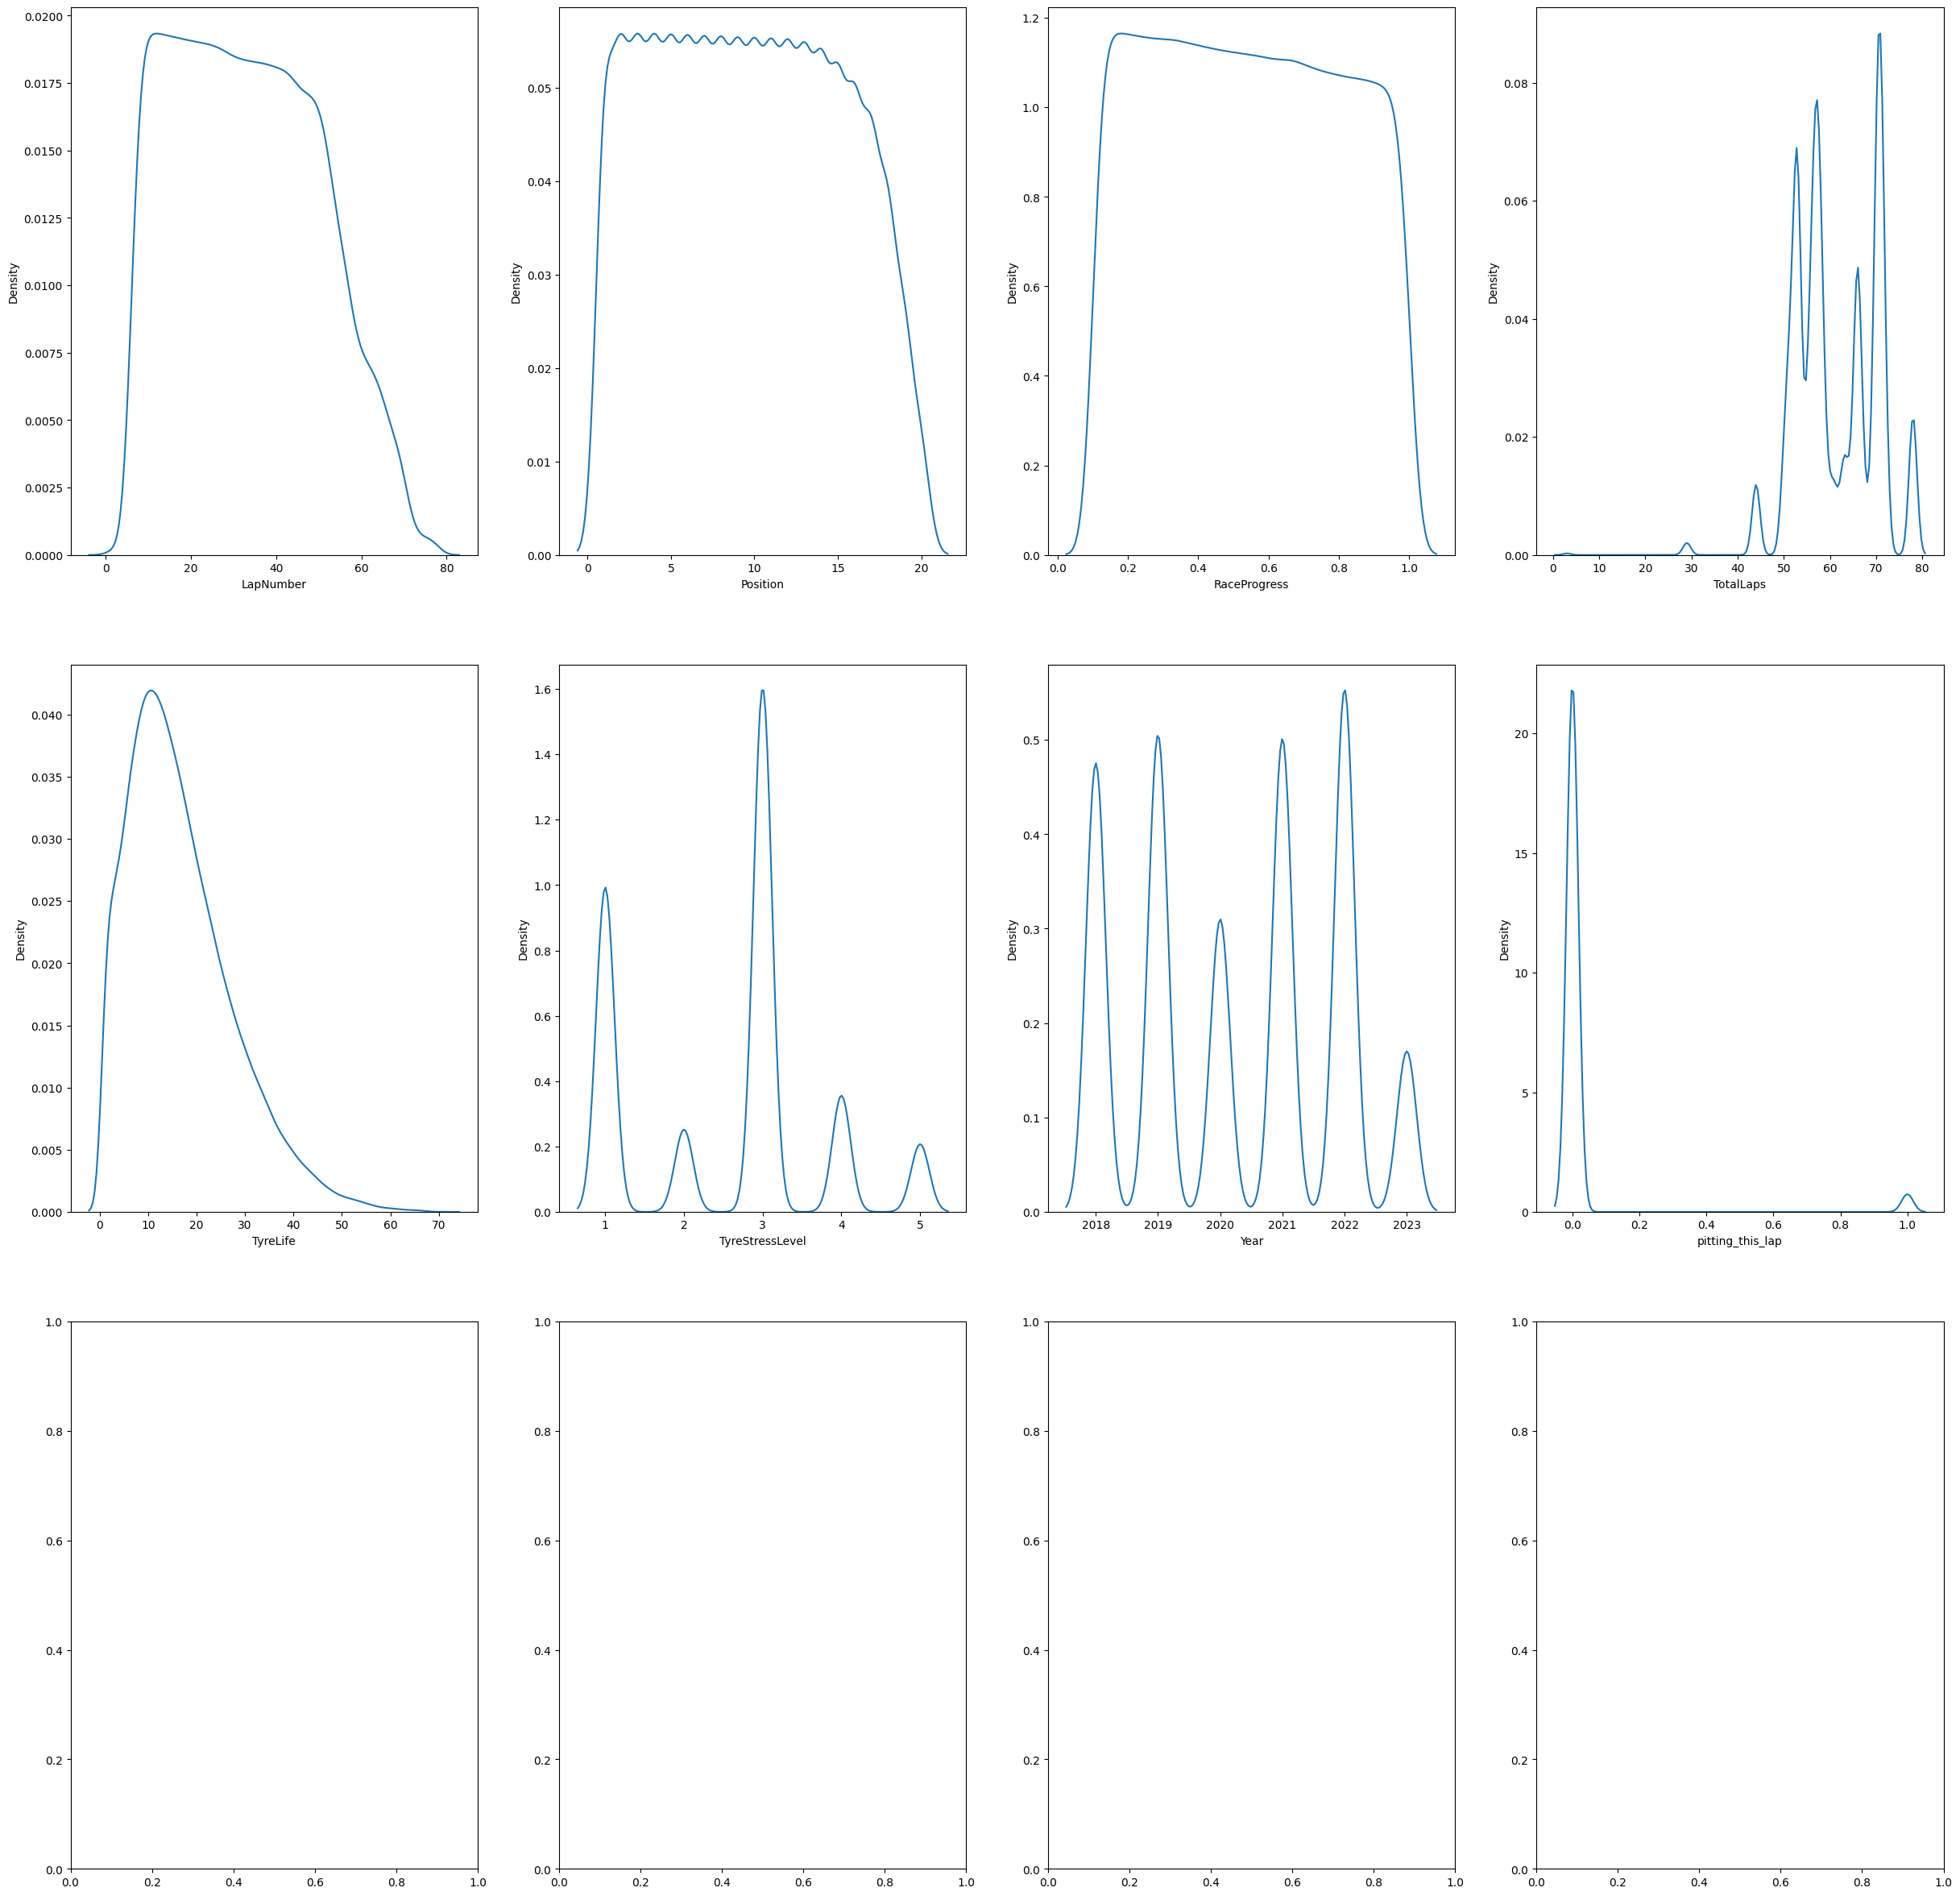

In [18]:
fig, axs = plt.subplots(3,4, figsize=(30, 30))

axs = axs.ravel()

for ax, column in zip(axs, feat_numerical):
    sns.kdeplot(x=column, data=X, ax=ax)

In [19]:
X.columns

Index(['Driver', 'LapNumber', 'IsPersonalBest', 'TyreLife', 'FreshTyre',
       'Team', 'Position', 'Location', 'Year', 'TotalLaps', 'RaceProgress',
       'TyreStressLevel', 'pitting_this_lap'],
      dtype='object')

In [20]:
X.dtypes

Driver               object
LapNumber           float64
IsPersonalBest         bool
TyreLife            float64
FreshTyre              bool
Team                 object
Position            float64
Location             object
Year                  int64
TotalLaps           float64
RaceProgress        float64
TyreStressLevel       int64
pitting_this_lap      int64
dtype: object

In [21]:
laps

,Driver,LapNumber,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,Position,Location,Year,TotalLaps,RaceProgress,TyreStressLevel,pitting_this_lap
5,GAS,6.0,False,SOFT,5.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.103448,3,0
6,GAS,7.0,True,SOFT,6.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.120690,3,0
7,GAS,8.0,True,SOFT,7.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.137931,3,0
8,GAS,9.0,True,SOFT,8.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.155172,3,0
9,GAS,10.0,True,SOFT,9.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.172414,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,SAR,61.0,False,HARD,25.0,True,Williams,20.0,Barcelona,2023,66.0,0.924242,1,0
125755,SAR,62.0,False,HARD,26.0,True,Williams,20.0,Barcelona,2023,66.0,0.939394,1,0
125756,SAR,63.0,False,HARD,27.0,True,Williams,20.0,Barcelona,2023,66.0,0.954545,1,0
125757,SAR,64.0,False,HARD,28.0,True,Williams,20.0,Barcelona,2023,66.0,0.969697,1,0


In [22]:
cat_features = ["Driver", "Team", "IsPersonalBest", "FreshTyre", "Location"]
cat_features_preproc = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))
num_features = ["LapNumber", "TyreLife", "Position", "TotalLaps", "TyreStressLevel", "pitting_this_lap", "RaceProgress", "Year"]
num_features_preproc = make_pipeline(RobustScaler())

In [23]:
preproc_baseline = make_column_transformer((cat_features_preproc, cat_features),
                                           (num_features_preproc, num_features),
                                           remainder="passthrough")

In [24]:
preproc_baseline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Driver', 'Team', 'IsPersonalBest',
                                  'FreshTyre', 'Location']),
                                ('pipeline-2',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['LapNumber', 'TyreLife', 'Position',
                                  'TotalLaps', 'TyreStressLevel',
                                  'pitting_this_lap', 'RaceProgress',
                                  'Year'])])

In [25]:
preproc_baseline.fit(X_train)
X_train_preproc = preproc_baseline.transform(X_train)
X_test_preproc = preproc_baseline.transform(X_test)
X_val_preproc = preproc_baseline.transform(X_val)

/Users/rosemansion/.pyenv/versions/3.10.6/envs/f1-binottor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Model

In [26]:
x = np.asarray(X_train_preproc).astype(np.float32)
y = np.asarray(y_train).astype(np.float32)


In [27]:
X_train_preproc.shape, y_val.shape , y_train.shape

((72143, 98), (18036, 6), (72143, 6))

In [28]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

model = models.Sequential()

model.add(layers.Dense(32, activation="relu", input_dim = 98))

model.add(layers.Dense(6, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [29]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [30]:
model.fit(X_train_preproc, y_train, 
          batch_size=256, epochs=100, 
          validation_data=(X_val_preproc, y_val),
          callbacks=[es])

Epoch 1/100
282/282 [==============================] - 1s 1ms/step - loss: 1.1316 - accuracy: 0.5355 - val_loss: 0.8780 - val_accuracy: 0.6325
Epoch 2/100
282/282 [==============================] - 0s 805us/step - loss: 0.7892 - accuracy: 0.6707 - val_loss: 0.7202 - val_accuracy: 0.6969
Epoch 3/100
282/282 [==============================] - 0s 831us/step - loss: 0.6724 - accuracy: 0.7231 - val_loss: 0.6292 - val_accuracy: 0.7456
Epoch 4/100
282/282 [==============================] - 0s 761us/step - loss: 0.6011 - accuracy: 0.7590 - val_loss: 0.5737 - val_accuracy: 0.7722
Epoch 5/100
282/282 [==============================] - 0s 744us/step - loss: 0.5530 - accuracy: 0.7806 - val_loss: 0.5332 - val_accuracy: 0.7878
Epoch 6/100
282/282 [==============================] - 0s 833us/step - loss: 0.5174 - accuracy: 0.7977 - val_loss: 0.5013 - val_accuracy: 0.8038
Epoch 7/100
282/282 [==============================] - 0s 813us/step - loss: 0.4890 - accuracy: 0.8113 - val_loss: 0.4765 - val_accu

In [31]:
y_pred = model.predict(X_test_preproc)
y_pred

498/498 [==============================] - 0s 340us/step


array([[1.7816301e-14, 1.2761022e-31, 5.1281218e-05, 9.9994874e-01,
        2.8058029e-17, 7.7402650e-20],
       [2.8478293e-04, 6.4056837e-12, 7.5333422e-01, 2.4638097e-01,
        1.9064558e-10, 1.3585289e-16],
       [9.9983323e-01, 1.0698312e-10, 1.6670204e-04, 1.0655343e-10,
        3.3560624e-12, 8.0583750e-17],
       ...,
       [4.0850345e-10, 4.5049979e-05, 9.7798526e-01, 2.1969639e-02,
        1.7139318e-07, 4.0882727e-12],
       [9.8411185e-01, 1.3055534e-07, 2.1832653e-03, 1.3704746e-02,
        2.6798556e-13, 3.0925709e-17],
       [3.1588716e-06, 7.7939001e-12, 5.7745606e-01, 4.2254075e-01,
        8.3721274e-10, 7.0126890e-17]], dtype=float32)

In [32]:
y_pred[0].argmax()

3

In [33]:
y_pred_encode = []
for prediction in y_pred:
    y_pred_encode.append(prediction.argmax())
        
y_pred_encode

[3,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 3,
 3,
 0,
 0,
 0,
 3,
 0,
 3,
 1,
 0,
 3,
 0,
 0,
 3,
 0,
 2,
 0,
 3,
 3,
 0,
 0,
 0,
 2,
 3,
 2,
 1,
 0,
 3,
 3,
 3,
 3,
 2,
 0,
 0,
 0,
 2,
 3,
 2,
 3,
 2,
 0,
 2,
 3,
 0,
 2,
 1,
 2,
 0,
 3,
 2,
 1,
 3,
 1,
 0,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 0,
 2,
 3,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 3,
 0,
 2,
 0,
 2,
 2,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 2,
 2,
 3,
 2,
 3,
 2,
 3,
 1,
 2,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 3,
 3,
 0,
 0,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 0,
 3,
 2,
 0,
 0,
 3,
 3,
 3,
 2,
 0,
 0,
 3,
 0,
 3,
 2,
 0,
 2,
 3,
 0,
 3,
 2,
 0,
 2,
 2,
 2,
 3,
 2,
 1,
 2,
 3,
 2,
 0,
 2,
 2,
 3,
 0,
 0,
 3,
 3,
 3,
 2,
 3,
 2,
 0,
 0,
 0,
 3,
 2,
 0,
 2,
 2,
 1,
 0,
 0,
 2,
 3,
 3,
 2,
 3,
 3,
 0,
 3,
 2,
 2,
 3,
 3,
 3,
 0,
 2,
 0,
 2,
 3,
 0,
 0,
 0,
 2,
 3,
 3,
 3,
 0,
 0,
 3,
 2,
 0,
 3,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 3,
 1,
 0,
 0,
 0,
 0,
 3,
 0,
 1,
 0,
 2,
 3,
 0,
 2,
 3,
 0,
 2,
 2,
 0,


In [34]:
y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
y_classes

[3,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 3,
 3,
 0,
 0,
 0,
 3,
 0,
 3,
 1,
 0,
 3,
 0,
 0,
 3,
 0,
 2,
 0,
 3,
 3,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 0,
 3,
 3,
 3,
 3,
 2,
 0,
 0,
 0,
 2,
 3,
 3,
 3,
 2,
 0,
 3,
 3,
 0,
 2,
 1,
 3,
 0,
 3,
 2,
 1,
 3,
 1,
 0,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 3,
 0,
 2,
 0,
 2,
 2,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 3,
 2,
 3,
 2,
 3,
 2,
 3,
 1,
 2,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 3,
 3,
 0,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 0,
 3,
 2,
 0,
 0,
 3,
 3,
 3,
 2,
 0,
 0,
 3,
 0,
 3,
 2,
 0,
 2,
 3,
 0,
 3,
 2,
 0,
 2,
 2,
 2,
 3,
 2,
 1,
 2,
 3,
 2,
 0,
 2,
 2,
 3,
 0,
 0,
 3,
 3,
 3,
 2,
 3,
 2,
 0,
 0,
 0,
 3,
 2,
 0,
 2,
 2,
 1,
 0,
 0,
 2,
 3,
 3,
 2,
 3,
 3,
 0,
 3,
 2,
 2,
 3,
 3,
 3,
 0,
 2,
 0,
 2,
 3,
 0,
 0,
 0,
 2,
 3,
 3,
 2,
 0,
 0,
 3,
 2,
 0,
 3,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 3,
 1,
 0,
 0,
 2,
 0,
 3,
 0,
 1,
 0,
 2,
 3,
 0,
 2,
 3,
 0,
 2,
 2,
 0,


In [35]:
baseline_acc = accuracy_score(y_classes, y_pred_encode)
baseline_acc

0.9432575091114742

In [36]:
baseline_f1 = f1_score(y_classes, y_pred_encode, average='weighted')
baseline_f1

0.9431326055160308